<a href="https://colab.research.google.com/github/kekecatf/Colab/blob/main/MakinaOgrenmesiProje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install osmnx
!pip install networkx
!pip install joblib

In [3]:
import joblib
import osmnx as ox
import pandas as pd
import networkx as nx
import zipfile
import os

In [4]:
zip_file_name = "random_forest_model.zip"

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [5]:
model = joblib.load('/content/random_forest_model.pkl')
G = ox.load_graphml('/content/istanbul_yol_agi.graphml')

In [6]:
speed_limits = {
    "residential": 30,
    "living_street": 30,
    "secondary": 70,
    "tertiary": 70,
    "unclassified": 70,
    "primary": 90,
    "trunk": 90,
    "motorway": 120
}

features = []

for u, v, data in G.edges(data=True):
    highway_type = data.get("highway", "residential")

    if isinstance(highway_type, list):
        highway_type = highway_type[0]

    data['speed_kph'] = speed_limits.get(highway_type, 50)

    features.append({
        'length': data.get('length', 0),
        'speed_kph': data.get('speed_kph', 50),
        'traffic_density': data.get('traffic_density', 0),
        'average_speed': data.get('average_speed', 50)
    })

features_df = pd.DataFrame(features)

travel_times = model.predict(features_df)

for (u, v, data), travel_time in zip(G.edges(data=True), travel_times):
    data['travel_time'] = travel_time

Toplam mesafe: 106.38 km
Toplam tahmini süre: 45.35 dakika


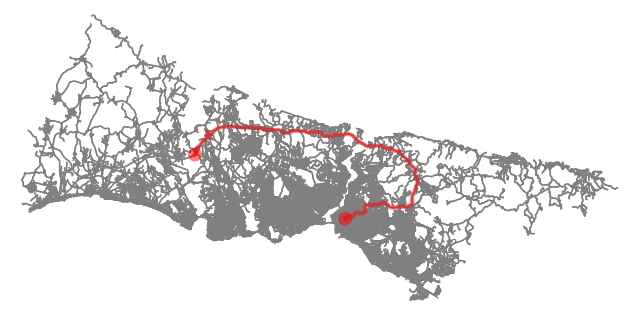

In [7]:
latitude1, longitude1 = 41.174698, 28.555968
latitude2, longitude2 = 41.015380, 29.053818

source = ox.distance.nearest_nodes(G, longitude1, latitude1)
target = ox.distance.nearest_nodes(G, longitude2, latitude2)

shortest_path = nx.shortest_path(G, source, target, weight='travel_time')

total_length = sum(G[u][v][0].get('length', 0) for u, v in zip(shortest_path[:-1], shortest_path[1:]))
total_travel_time = sum(G[u][v][0].get('travel_time', 0) for u, v in zip(shortest_path[:-1], shortest_path[1:]))

print(f"Toplam mesafe: {total_length / 1000:.2f} km")
print(f"Toplam tahmini süre: {(total_travel_time + 300.0) / 60:.2f} dakika")

fig, ax = ox.plot_graph_route(G, shortest_path, route_linewidth=3, node_size=0, bgcolor='white', edge_color='gray', show=True, close=False)